In [1]:
#!pip install pandas

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
csv_log='wastewater'
df = pd.read_csv("../output/v2.1_b_0.8_t_0.4/"+csv_log+'.txt') #BPIC15_1, bpic2020, bpic2017_o, helpdesk, sepsis, mip

# distinct baselines: 356


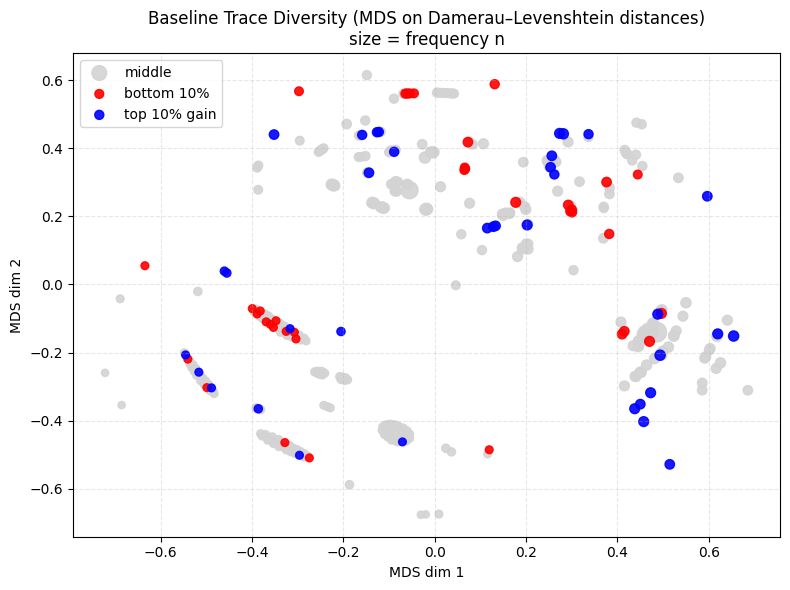

Saved: baseline_diversity_DL_MDS.csv
 trace_index               baseline_trace  n   avg_no  avg_with     gain         x         y
           0 847 848 1 2 3 22 12 13 16 10 45 0.315667  0.737333 0.421667  0.281377  0.442610
           1                   0 783 9 10 15 0.416667  0.791667 0.375000 -0.516193 -0.257802
           2                   858 1 9 10 15 0.666667  1.000000 0.333333 -0.295987 -0.502020
           3     0 802 803 11 12 13 16 10 35 0.367857  0.689286 0.321429 -0.351635  0.440403
           4      850 1 2 3 851 852 13 13 35 0.153286  0.470714 0.317429  0.596572  0.259159
           5                   0 782 9 10 15 0.500000  0.791667 0.291667 -0.545170 -0.207103
           6               0 1 693 694 10 20 0.220750  0.491500 0.270750 -0.454952  0.033627
           7               0 1 939 940 10 20 0.220750  0.491500 0.270750 -0.460268  0.039048
           8               0 1 998 999 10 20 0.220750  0.491500 0.270750 -0.205112 -0.138275
           9          0 846 2 3 4

In [2]:
seq_cols = ['Prefix','Predicted_NoFreq','Predicted_WithFreq','Truth']
mask_keep = ~df[seq_cols].apply(lambda s: s.astype(str).str.contains(r'\bend\b', case=False, na=False)).any(axis=1)
df = df[mask_keep].copy()

num_pat = re.compile(r'-?\d+')
def parse_seq(x): return [int(t) for t in num_pat.findall(str(x))]
for c in seq_cols:
    df[c + '_seq'] = df[c].astype(str).apply(parse_seq)

# ========= 2) Baseline = Prefix + Truth; aggregate (freq, avg DLs, gain) =========
df['baseline_seq'] = [p + t for p, t in zip(df['Prefix_seq'], df['Truth_seq'])]
def seq_key(s): return "-".join(map(str, s)) if s else ""
df['baseline_key'] = df['baseline_seq'].apply(seq_key)
df = df[df['baseline_key'] != ""].copy()

agg = (
    df.groupby('baseline_key', as_index=False)
      .agg(
          avg_no=('DL_Score_NoFreq','mean'),
          avg_with=('DL_Score_WithFreq','mean'),
          n=('baseline_key','size')
      )
)
agg['gain'] = agg['avg_with'] - agg['avg_no']

# keep one representative baseline sequence per key (for distances)
rep = df.groupby('baseline_key')['baseline_seq'].first()
keys = rep.index.tolist()
seqs = rep.tolist()
K = len(seqs)
print(f"# distinct baselines: {K}")

# ========= 3) Damerau–Levenshtein for integer sequences =========
def dl_distance(a, b):
    """Damerau–Levenshtein distance allowing adjacent transpositions."""
    m, n = len(a), len(b)
    if m == 0: return n
    if n == 0: return m
    # classic O(mn) DP with transpositions
    d = [[0]*(n+1) for _ in range(m+1)]
    for i in range(m+1): d[i][0] = i
    for j in range(n+1): d[0][j] = j
    for i in range(1, m+1):
        for j in range(1, n+1):
            cost = 0 if a[i-1] == b[j-1] else 1
            d[i][j] = min(
                d[i-1][j] + 1,      # deletion
                d[i][j-1] + 1,      # insertion
                d[i-1][j-1] + cost  # substitution
            )
            if i>1 and j>1 and a[i-1]==b[j-2] and a[i-2]==b[j-1]:
                d[i][j] = min(d[i][j], d[i-2][j-2] + 1)  # transposition
    return d[m][n]

def dl_norm(a, b):
    denom = max(len(a), len(b))
    if denom == 0: return 0.0
    return dl_distance(a, b) / denom   # normalized to [0,1]

# ========= 4) Pairwise distance matrix (DL) =========
D = np.zeros((K, K), dtype=float)
for i in range(K):
    for j in range(i+1, K):
        d = dl_norm(seqs[i], seqs[j])
        D[i, j] = D[j, i] = d

# ========= 5) MDS on the DL distance matrix =========
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0, n_init=4, max_iter=800)
XY = mds.fit_transform(D)
coords = pd.DataFrame(XY, columns=['x','y'])
coords['baseline_key'] = keys

# attach coords back to agg
agg = agg.merge(coords, on='baseline_key', how='left')

# ========= 6) Colors & sizes =========
q10, q90 = agg['gain'].quantile(0.10), agg['gain'].quantile(0.90)
def color_label(g):
    if g >= q90: return "blue", "top 10% gain"
    if g <= q10: return ("yellow", "bottom 10% (gain>0)") if g > 0 else ("red", "bottom 10%")
    return "lightgray", "middle"
agg[['color','label']] = agg['gain'].apply(lambda g: pd.Series(color_label(g)))

sizes = 20 + 180 * (agg['n'] / agg['n'].max())  # frequency-scaled markers

# ========= 7) Plot: DL-based diversity =========
plt.figure(figsize=(8,6))
for label in ['middle', 'bottom 10% (gain>0)', 'bottom 10%', 'top 10% gain']:
    m = agg['label'].eq(label)
    if m.any():
        plt.scatter(agg.loc[m,'x'], agg.loc[m,'y'],
                    s=sizes[m], alpha=0.9, c=agg.loc[m,'color'], label=label)
plt.title('Baseline Trace Diversity (MDS on Damerau–Levenshtein distances)\nsize = frequency n')
plt.xlabel('MDS dim 1'); plt.ylabel('MDS dim 2')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ========= 8) Save lookup table =========
agg_sorted = agg.sort_values('gain', ascending=False, kind='mergesort').reset_index(drop=True)
agg_sorted['trace_index'] = np.arange(len(agg_sorted))
agg_sorted['baseline_trace'] = agg_sorted['baseline_key'].str.replace('-', ' ')
cols = ['trace_index','baseline_trace','n','avg_no','avg_with','gain','x','y']
agg_sorted[cols].to_csv('baseline_diversity_DL_MDS.csv', index=False)
print("Saved: baseline_diversity_DL_MDS.csv")
print(agg_sorted[cols].head(10).to_string(index=False))


      Prefix Predicted_NoFreq Predicted_WithFreq    Truth  DL_Score_NoFreq  \
0          0          8 3 4 5            8 3 4 5  1 3 4 5            0.857   
1        0 1            3 4 5              3 4 5    3 4 5            1.000   
2      0 1 3              4 5                4 5      4 5            1.000   
3    0 1 3 4                5                  5        5            1.000   
4  0 1 3 4 5              end                end      end            1.000   

   DL_Score_WithFreq   avg_noFreq   avg_withfreq  
0              0.857        0.857          0.857  
1              1.000        0.929          0.929  
2              1.000        0.952          0.952  
3              1.000        0.964          0.964  
4              1.000        0.971          0.971  


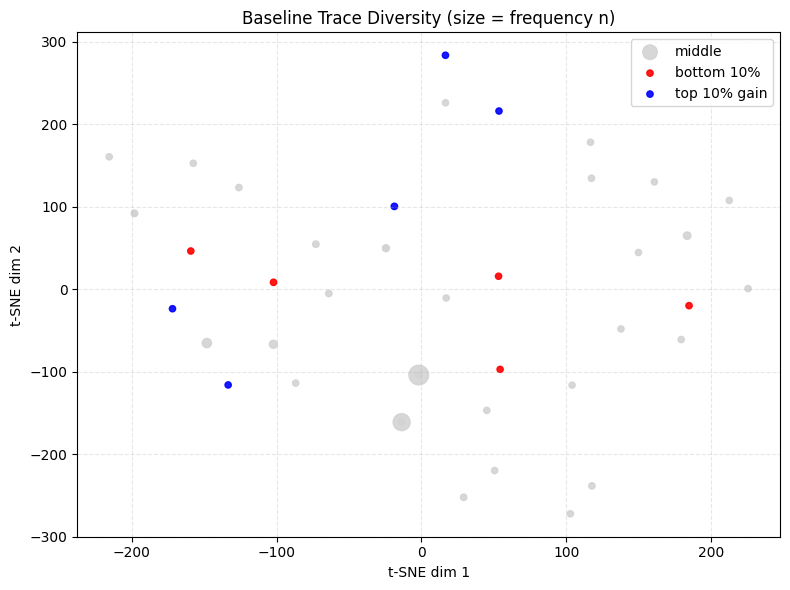

Saved: baseline_diversity_with_gain.csv
 trace_index                          baseline_trace    n   avg_no  avg_with     gain           x           y
           0                       0 6 0 6 0 6 0 6 7    6 0.329833  0.496500 0.166667   53.597435  216.011032
           1 0 6 7 0 6 7 0 6 7 0 6 7 0 6 7 0 1 3 4 5   19 0.522579  0.566474 0.043895   16.624517  283.633331
           2                           0 6 0 1 3 4 5   12 0.776583  0.809417 0.032833 -133.464294 -116.112915
           3                       0 6 0 7 0 1 3 4 5    8 0.735250  0.757500 0.022250 -171.906982  -23.680239
           4                   0 1 2 9 7 0 1 2 3 4 5   40 0.801125  0.821900 0.020775  -18.652695  100.396736
           5                   0 6 7 0 6 7 0 1 3 4 5   30 0.779000  0.792300 0.013300 -126.020416  123.209923
           6                               0 1 3 4 5 4968 0.952936  0.962038 0.009102   -1.797260 -104.096947
           7                    0 1 14 7 0 1 2 3 4 5   34 0.781500  0.789912 0.0

In [3]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE

# ---------- load & clean ----------
csv_log='bpic2020'
df = pd.read_csv("../output/v2.1_b_0.8_t_0.4/"+csv_log+'.txt') #BPIC15_1, bpic2020, bpic2017_o, helpdesk, sepsis, mip
print(df.head())

seq_cols = ['Prefix','Predicted_NoFreq','Predicted_WithFreq','Truth']
mask_keep = ~df[seq_cols].apply(lambda s: s.astype(str).str.contains(r'\bend\b', case=False, na=False)).any(axis=1)
df = df[mask_keep].copy()

num_pat = re.compile(r'-?\d+')
def parse_seq(x): return [int(t) for t in num_pat.findall(str(x))]
def seq_key(seq): return "-".join(map(str, seq)) if seq else ""

for c in seq_cols:
    df[c + '_seq'] = df[c].astype(str).apply(parse_seq)

# ---------- baseline trace = Prefix + Truth ----------
df['baseline_seq'] = [p + t for p, t in zip(df['Prefix_seq'], df['Truth_seq'])]
df['baseline_key'] = df['baseline_seq'].apply(seq_key)
df = df[df['baseline_key'] != ""].copy()

# ---------- aggregate per distinct baseline trace ----------
agg = (
    df.groupby('baseline_key', as_index=False)
      .agg(
          avg_no=('DL_Score_NoFreq','mean'),
          avg_with=('DL_Score_WithFreq','mean'),
          n=('baseline_key','size')  # frequency
      )
)
agg['gain'] = agg['avg_with'] - agg['avg_no']

# keep one representative sequence per baseline (for embedding)
rep_seq = df.groupby('baseline_key')['baseline_seq'].first()

# ---------- embed baselines to 2D (bag-of-activities + t-SNE) ----------
vocab = sorted({a for s in rep_seq for a in s})
idx = {a:i for i,a in enumerate(vocab)}
X = np.zeros((len(rep_seq), len(vocab)), dtype=float)
for row_i, key in enumerate(rep_seq.index):
    for a, f in Counter(rep_seq.loc[key]).items():
        X[row_i, idx[a]] = f

# pick a safe perplexity
perpl = max(5, min(30, len(rep_seq)//3 if len(rep_seq) >= 9 else 5))
emb = TSNE(n_components=2, perplexity=perpl, random_state=0).fit_transform(X)

# attach embedding back to agg in same order
coords = pd.DataFrame(emb, index=rep_seq.index, columns=['x','y']).reset_index().rename(columns={'index':'baseline_key'})
agg = agg.merge(coords, on='baseline_key', how='left')

# ---------- color categories ----------
q10, q90 = agg['gain'].quantile(0.10), agg['gain'].quantile(0.90)

def color_and_label(g):
    if g >= q90:
        return "blue", "top 10% gain"
    if g <= q10:
        return ("yellow", "bottom 10% (gain>0)") if g > 0 else ("red", "bottom 10%")
    return "lightgray", "middle"

agg[['color','label']] = agg['gain'].apply(lambda g: pd.Series(color_and_label(g)))

# ---------- sizes by frequency (n) ----------
size = 20 + 180 * (agg['n'] / agg['n'].max())

# ---------- plot: diversity with frequency & highlights ----------
plt.figure(figsize=(8,6))
# plot middle first, then bottom, then top for visibility
for label in ['middle', 'bottom 10% (gain>0)', 'bottom 10%', 'top 10% gain']:
    m = agg['label'].eq(label)
    if m.any():
        plt.scatter(agg.loc[m,'x'], agg.loc[m,'y'],
                    s=size[m], alpha=0.9, c=agg.loc[m,'color'], label=label)

plt.title('Baseline Trace Diversity (size = frequency n)')
plt.xlabel('t-SNE dim 1'); plt.ylabel('t-SNE dim 2')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ---------- also keep a lookup table ----------
# Sort by gain for convenience and assign an index
agg_sorted = agg.sort_values('gain', ascending=False, kind='mergesort').reset_index(drop=True)
agg_sorted['trace_index'] = np.arange(len(agg_sorted))
# human-readable baseline string
agg_sorted['baseline_trace'] = agg_sorted['baseline_key'].str.replace('-', ' ')
cols = ['trace_index','baseline_trace','n','avg_no','avg_with','gain','x','y']
agg_sorted[cols].to_csv('baseline_diversity_with_gain.csv', index=False)
print("Saved: baseline_diversity_with_gain.csv")
print(agg_sorted[cols].head(10).to_string(index=False))


        Prefix                                   Predicted_NoFreq  \
0            0  1 1 12 0 0 0 0 0 0 0 0 5 13 13 13 14 13 14 13 ...   
1          0 7  5 5 5 5 5 5 5 5 5 5 5 5 13 14 13 5 14 5 5 5 5 ...   
2        0 7 4  6 0 0 0 10 3 8 7 8 5 5 13 14 13 13 14 14 16 16...   
3     0 7 4 26  6 7 7 10 10 3 8 7 5 13 13 13 14 14 16 16 0 0 0...   
4  0 7 4 26 10  1 7 1 10 10 7 5 13 13 13 13 13 14 14 16 0 0 0 ...   

                                  Predicted_WithFreq  \
0  0 7 10 35 6 12 1 4 26 0 3 8 12 13 7 10 14 16 0...   
1  4 26 5 30 5 0 1 8 27 5 6 0 7 0 12 5 17 5 0 3 5...   
2  28 8 10 12 0 1 2 24 5 3 13 14 13 14 15 13 14 1...   
3  28 0 6 10 4 33 1 7 5 3 8 13 14 13 14 15 16 0 1...   
4  0 6 10 4 33 1 7 5 3 8 13 14 13 14 15 16 0 10 4...   

                                               Truth  DL_Score_NoFreq  \
0  7 4 26 10 12 34 3 6 8 0 12 3 24 1 7 5 10 11 32...            0.467   
1  4 26 10 12 34 3 6 8 0 12 3 24 1 7 5 10 11 32 3...            0.404   
2  26 10 12 34 3 6 8 0 12 3 2

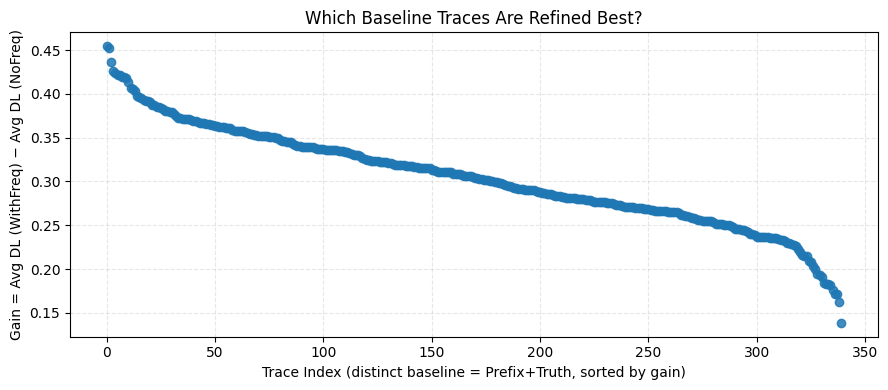

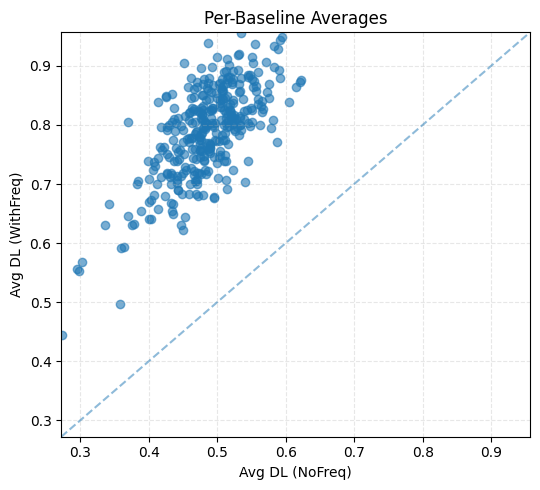

Saved: baseline_trace_gain_ranking.csv
 trace_index                                                                                                                                      baseline_trace   avg_no  avg_with     gain  n  avg_prefix_len  baseline_len
           0                           0 5 3 1 0 8 28 5 25 0 8 9 10 12 3 5 5 24 0 5 0 27 0 30 5 12 5 10 7 4 24 3 6 13 8 14 5 15 5 16 0 4 6 8 7 12 10 19 20 31 23 0.451260  0.905700 0.454440 50            25.5          51.0
           1                        0 1 10 12 7 13 14 15 0 25 12 3 5 7 10 35 6 8 13 14 13 14 16 0 7 5 0 5 0 5 8 27 17 19 18 5 20 21 5 19 20 21 5 0 19 5 20 31 23 0.486167  0.938979 0.452812 48            24.5          49.0
           2                                0 17 5 0 5 25 1 8 3 0 11 5 6 8 0 4 5 3 25 28 11 27 33 24 5 7 5 9 10 5 0 6 5 4 26 0 10 13 5 14 16 0 7 0 1 19 20 31 23 0.369479  0.805500 0.436021 48            24.5          49.0
           3    0 5 9 7 10 12 0 5 10 27 35 6 34 0 1 7 12 25 5 5 10 32 33 

In [3]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== 1) Load your TXT =====
# If your file is tab-separated, use sep="\t"
csv_log='mip'
df = pd.read_csv("../output/v2.1_b_0.8_t_0.4/"+csv_log+'.txt') #BPIC15_1, bpic2020, bpic2017_o, helpdesk, sepsis, mip
print(df.head())

# ===== 2) Clean rows with 'end' in any sequence column =====
seq_cols = ['Prefix','Predicted_NoFreq','Predicted_WithFreq','Truth']
mask_keep = ~df[seq_cols].apply(lambda s: s.astype(str).str.contains(r'\bend\b', case=False, na=False)).any(axis=1)
df = df[mask_keep].copy()

# ===== 3) Helpers to parse sequences and stringify keys =====
num_pat = re.compile(r'-?\d+')

def parse_seq(x: str):
    return [int(t) for t in num_pat.findall(str(x))]

def seq_to_key(seq):
    # stable string key for grouping
    return "-".join(map(str, seq)) if seq else ""

# parse the four sequence columns
for c in seq_cols:
    df[c + '_seq'] = df[c].astype(str).apply(parse_seq)

# ===== 4) Build the baseline full trace: Prefix + Truth =====
df['baseline_seq'] = [p + t for p, t in zip(df['Prefix_seq'], df['Truth_seq'])]
df['baseline_key'] = df['baseline_seq'].apply(seq_to_key)

# drop empties if any
df = df[df['baseline_key'] != ""].copy()

# ===== 5) Aggregate per distinct baseline full trace =====
# We want the average predicted DL and refined DL for each baseline
agg = (
    df.groupby('baseline_key', as_index=False)
      .agg(
          avg_no=('DL_Score_NoFreq','mean'),
          avg_with=('DL_Score_WithFreq','mean'),
          n=('baseline_key','size'),
          # optional diagnostics:
          avg_prefix_len=('Prefix_seq', lambda s: np.mean([len(x) for x in s])),
          baseline_len=('baseline_seq',  lambda s: np.mean([len(x) for x in s])),
      )
)

agg['gain'] = agg['avg_with'] - agg['avg_no']

# ===== 6) Sort by gain, give each baseline a stable index =====
agg = agg.sort_values('gain', ascending=False, kind='mergesort').reset_index(drop=True)
agg['trace_index'] = np.arange(len(agg))  # 0-based; use +1 for 1-based

# human-readable baseline string
def key_to_pretty(s): return s.replace('-', ' ')
agg['baseline_trace'] = agg['baseline_key'].apply(key_to_pretty)

# ===== 7) Plot: trace index vs gain =====
plt.figure(figsize=(9,4))
plt.plot(agg['trace_index'], agg['gain'], marker='o', linestyle='None', alpha=0.85)
plt.xlabel('Trace Index (distinct baseline = Prefix+Truth, sorted by gain)')
plt.ylabel('Gain = Avg DL (WithFreq) − Avg DL (NoFreq)')
plt.title('Which Baseline Traces Are Refined Best?')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# (nice sanity plot) avg_no vs avg_with with y=x line
plt.figure(figsize=(5.5,5))
plt.scatter(agg['avg_no'], agg['avg_with'], alpha=0.6)
lims = [min(agg[['avg_no','avg_with']].min())-1e-3, max(agg[['avg_no','avg_with']].max())+1e-3]
plt.plot(lims, lims, '--', alpha=0.5)
plt.xlim(lims); plt.ylim(lims)
plt.xlabel('Avg DL (NoFreq)'); plt.ylabel('Avg DL (WithFreq)')
plt.title('Per-Baseline Averages')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# ===== 8) Save lookup table (index → baseline & stats) =====
out_cols = ['trace_index','baseline_trace','avg_no','avg_with','gain','n','avg_prefix_len','baseline_len']
agg[out_cols].to_csv('baseline_trace_gain_ranking.csv', index=False)
print("Saved: baseline_trace_gain_ranking.csv")
print(agg[out_cols].head(10).to_string(index=False))

